In [4]:
# Import required packages\n",
import os
import numpy as np
import pandas as pd
import math
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.transforms import ToPILImage
from torch.nn.init import kaiming_uniform
from torchvision.transforms import Resize, ToTensor, Compose
import matplotlib.pyplot as plt
import cv2

In [5]:
# Import the yield data as pandas data frame (Note this is saved as a csv file in base working directory)
file_path = os.path.join(os.getcwd()) + '/train_data/'
# Yield file below has been modified slightly to align the name of the country in the CSV file with that of the numpy array
file_name = 'yield_PR.csv'
yield_data = pd.read_csv(file_path + file_name)

In [6]:
class CustomImageDataset():
    def __init__(self, hist_dir, crop_yield_table, transform=None, target_transform=None):  
        self.hist_dir = hist_dir # References the directory for each given country where the data is stored
        self.transform = transform
        self.target_transform = target_transform
        # load the files 
        filenames = [] # For every year, yields a numpy array of dimension 576 x 46
        crop_yields = []
        for filename in os.listdir(hist_dir):
            if filename != 'yield.csv' and filename != 'yield_PR.csv':
                filenames.append(filename)
                crop_yields.append(crop_yield_table[crop_yield_table['Country Name'] == filename[:-9]][str(int(filename[-8:-4]))].to_numpy())
        self.filenames = filenames
        self.crop_yields = crop_yields
        
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        hist_dir = os.path.join(self.hist_dir, self.filenames[idx])
        hist = np.load(hist_dir)
       
        # Turn into 3 channel array (triplicate of single layer) --> to function with known model architectures
        hist_3 = np.zeros( ( np.array(hist).shape[0], np.array(hist).shape[1], 1 ) )
        hist_3[:,:,0] = hist # same value in each channel
        
        if self.transform:
            hist = self.transform(hist_3).float()
        crop_yield = torch.from_numpy(self.crop_yields[idx].reshape(-1, 1)).float()
        return hist, crop_yield

In [7]:
# Create_Training_Dataset
crop_dataset_train = CustomImageDataset('./train_data/', crop_yield_table = yield_data, transform = Compose([ToTensor(), Resize((28,28))]))

# Create_Training_Dataset
crop_dataset_test = CustomImageDataset('./test_data/', crop_yield_table = yield_data, transform = Compose([ToTensor(), Resize((28,28))]))


In [8]:
crop_dataset_train[3] # Shows for a given tensor which consists of a pair of 1) array of binned histogram data; and 2) yield output

(tensor([[[6.2500e-04, 5.5607e-04, 8.4570e-03, 1.5709e-03, 2.3179e-02,
           1.3981e-03, 3.0051e-03, 1.2917e-03, 4.4415e-03, 6.3344e-03,
           2.6151e-02, 5.5248e-02, 7.0968e-02, 7.0595e-02, 9.2795e-02,
           9.3365e-02, 9.2082e-02, 6.5998e-02, 3.8907e-02, 2.8165e-02,
           2.4699e-02, 1.4099e-02, 7.8688e-03, 3.8811e-03, 4.7234e-03,
           1.7640e-03, 2.9244e-03, 2.7284e-03],
          [0.0000e+00, 0.0000e+00, 9.6811e-04, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

In [9]:
crop_dataset_train[3][0].shape # For each binned histogram data, consists of 576 observations across 29 dimensions

torch.Size([1, 28, 28])

type of the image:  <class 'torch.Tensor'>
Yield: tensor([[1058.6000]])


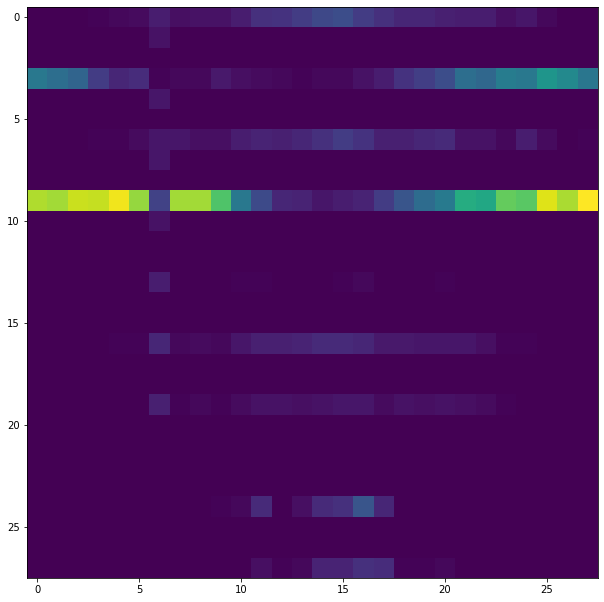

In [10]:
# Plot data for one sample pair
raw_image, crop_yield = crop_dataset_train[0]
figure = plt.figure()
figure.set_size_inches(18.5, 10.5)

print("type of the image: ", type(raw_image))

if type(raw_image) == torch.Tensor:
    plt.imshow(ToPILImage()(raw_image))
else:
    plt.imshow(raw_image)
    
print(f"Yield: {crop_yield}")

In [11]:
raw_image.shape

torch.Size([1, 28, 28])

In [12]:
# Initialize data loaders
train_dataloader = DataLoader(crop_dataset_train, batch_size=1, shuffle=False)
test_dataloader = DataLoader(crop_dataset_test, batch_size=1, shuffle=False)

In [13]:
# Check device used
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [14]:
# Basic Neural Network as outlined in lecture notes
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()       
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [15]:
model = NeuralNetwork().to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [16]:
# Train model
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    correct, train_loss = 0, 0 
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()  
        loss.backward()
        optimizer.step() 
    train_loss /= num_batches
    return train_loss 

In [17]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() 
    
    test_val = pd.DataFrame(columns = ['Actual', 'Predicted', 'Error', 'Error_sq', 'Perc_Err'])
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).item()
            pred = model(X).item()
                    
            test_val = test_val.append({'Actual' : y, 'Predicted' : pred , 'Error' : abs(pred - y),  'Error_sq': (pred - y)**2, 'Perc_Err' : abs(pred - y) / y}, ignore_index = True)

    return test_val

In [18]:
epochs = 500
train_loss_history = []
test_history_RMSE = []
test_history_MAPE = []

for t in range(epochs):
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_vals = test(test_dataloader, model)
    train_loss_history.append(train_loss)
    test_history_RMSE.append(math.sqrt(test_vals['Error_sq'].sum() / test_vals['Error_sq'].count()))
    test_history_MAPE.append(test_vals['Perc_Err'].mean())
    # test_loss, test_acc = test(testloader, model, loss_fn)
    if t%1 == 0:
        print(f"Epoch {t}:")
        print(f"Avg training loss: {train_loss:>8f}")
        print(f"Root Mean Squared Error: {math.sqrt(test_vals['Error_sq'].sum() / test_vals['Error_sq'].count())}")
        print(f"Mean Average Percentage Error: {test_vals['Perc_Err'].mean()}")
print("Done!")

C:\Users\paulr\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0:
Avg training loss: 3841548.992961
Root Mean Squared Error: 1926.5979362774979
Mean Average Percentage Error: 0.8417864688598706
Epoch 1:
Avg training loss: 3122040.619052
Root Mean Squared Error: 1662.529485926564
Mean Average Percentage Error: 0.6027233400108781
Epoch 2:
Avg training loss: 2375266.308213
Root Mean Squared Error: 1449.0193384493996
Mean Average Percentage Error: 0.5632882375416569
Epoch 3:
Avg training loss: 2020301.068757
Root Mean Squared Error: 1362.414450421073
Mean Average Percentage Error: 0.5716804394980817
Epoch 4:
Avg training loss: 1914381.443368
Root Mean Squared Error: 1333.9253696342164
Mean Average Percentage Error: 0.5901051721926994
Epoch 5:
Avg training loss: 1876466.250152
Root Mean Squared Error: 1321.9952429318175
Mean Average Percentage Error: 0.5987269567367776
Epoch 6:
Avg training loss: 1854565.126008
Root Mean Squared Error: 1315.2800045443184
Mean Average Percentage Error: 0.6026515206668793
Epoch 7:
Avg training loss: 1838067.227171


Epoch 60:
Avg training loss: 1370383.304469
Root Mean Squared Error: 1153.6332765981635
Mean Average Percentage Error: 0.5914567774506682
Epoch 61:
Avg training loss: 1358548.225037
Root Mean Squared Error: 1149.131654521028
Mean Average Percentage Error: 0.5899955306197934
Epoch 62:
Avg training loss: 1346617.571565
Root Mean Squared Error: 1144.5503654429558
Mean Average Percentage Error: 0.5884156708746
Epoch 63:
Avg training loss: 1334496.584722
Root Mean Squared Error: 1139.9083573404494
Mean Average Percentage Error: 0.586715429473894
Epoch 64:
Avg training loss: 1322159.954303
Root Mean Squared Error: 1135.1211457049428
Mean Average Percentage Error: 0.5849297838429406
Epoch 65:
Avg training loss: 1309605.000699
Root Mean Squared Error: 1130.2120263681693
Mean Average Percentage Error: 0.5830597454172174
Epoch 66:
Avg training loss: 1296949.258837
Root Mean Squared Error: 1125.2317760287071
Mean Average Percentage Error: 0.5810573302126021
Epoch 67:
Avg training loss: 1284050.99

Epoch 120:
Avg training loss: 591680.199782
Root Mean Squared Error: 774.4294365491758
Mean Average Percentage Error: 0.4518150057679686
Epoch 121:
Avg training loss: 583130.077925
Root Mean Squared Error: 769.1409505465184
Mean Average Percentage Error: 0.4503580877888893
Epoch 122:
Avg training loss: 574763.326838
Root Mean Squared Error: 763.9899978492155
Mean Average Percentage Error: 0.44886582266839253
Epoch 123:
Avg training loss: 566588.616189
Root Mean Squared Error: 758.9053756142097
Mean Average Percentage Error: 0.4475241849512041
Epoch 124:
Avg training loss: 558554.473856
Root Mean Squared Error: 753.8374046941764
Mean Average Percentage Error: 0.44626481927348455
Epoch 125:
Avg training loss: 550663.057069
Root Mean Squared Error: 748.8543498133685
Mean Average Percentage Error: 0.44500616142978594
Epoch 126:
Avg training loss: 542905.030469
Root Mean Squared Error: 743.9413202145442
Mean Average Percentage Error: 0.4437695321326647
Epoch 127:
Avg training loss: 535304.7

Epoch 180:
Avg training loss: 307667.991957
Root Mean Squared Error: 586.1066984279859
Mean Average Percentage Error: 0.3938698148256914
Epoch 181:
Avg training loss: 305802.996745
Root Mean Squared Error: 585.0134158201492
Mean Average Percentage Error: 0.39295513322817643
Epoch 182:
Avg training loss: 303955.178124
Root Mean Squared Error: 583.8996537543862
Mean Average Percentage Error: 0.3920222143478728
Epoch 183:
Avg training loss: 302045.162860
Root Mean Squared Error: 582.8118950383307
Mean Average Percentage Error: 0.3911787863983025
Epoch 184:
Avg training loss: 300348.436356
Root Mean Squared Error: 581.7009167732424
Mean Average Percentage Error: 0.3901359090752303
Epoch 185:
Avg training loss: 298530.046374
Root Mean Squared Error: 580.6481068916526
Mean Average Percentage Error: 0.38941157099593043
Epoch 186:
Avg training loss: 296965.842253
Root Mean Squared Error: 579.6482094818526
Mean Average Percentage Error: 0.3884772497091661
Epoch 187:
Avg training loss: 295286.05

Epoch 240:
Avg training loss: 240942.990172
Root Mean Squared Error: 557.1344604333775
Mean Average Percentage Error: 0.3582108867043405
Epoch 241:
Avg training loss: 240147.938809
Root Mean Squared Error: 556.9371162669901
Mean Average Percentage Error: 0.35804817966188834
Epoch 242:
Avg training loss: 239525.796960
Root Mean Squared Error: 556.8240760849246
Mean Average Percentage Error: 0.3577735710629835
Epoch 243:
Avg training loss: 238793.843230
Root Mean Squared Error: 556.6870765310407
Mean Average Percentage Error: 0.3576224561962159
Epoch 244:
Avg training loss: 238028.629935
Root Mean Squared Error: 556.5723848577488
Mean Average Percentage Error: 0.357361398706947
Epoch 245:
Avg training loss: 237373.773205
Root Mean Squared Error: 556.5181437474183
Mean Average Percentage Error: 0.3572586398317597
Epoch 246:
Avg training loss: 236688.445498
Root Mean Squared Error: 556.4151650556099
Mean Average Percentage Error: 0.35701223956648753
Epoch 247:
Avg training loss: 235975.072

Epoch 300:
Avg training loss: 205654.845386
Root Mean Squared Error: 563.0481862036983
Mean Average Percentage Error: 0.3566414405601655
Epoch 301:
Avg training loss: 205192.419409
Root Mean Squared Error: 563.1830324287462
Mean Average Percentage Error: 0.35658225424188633
Epoch 302:
Avg training loss: 204688.351362
Root Mean Squared Error: 563.5713790224872
Mean Average Percentage Error: 0.3566279579744551
Epoch 303:
Avg training loss: 204214.001366
Root Mean Squared Error: 563.7566546527199
Mean Average Percentage Error: 0.35656101174783533
Epoch 304:
Avg training loss: 203759.138405
Root Mean Squared Error: 564.0730767326424
Mean Average Percentage Error: 0.35664352699316393
Epoch 305:
Avg training loss: 203325.296972
Root Mean Squared Error: 564.2610986236436
Mean Average Percentage Error: 0.35657804497302065
Epoch 306:
Avg training loss: 202852.466953
Root Mean Squared Error: 564.5405935932184
Mean Average Percentage Error: 0.3565573413497479
Epoch 307:
Avg training loss: 202357.

Epoch 360:
Avg training loss: 181981.885400
Root Mean Squared Error: 565.9453428757205
Mean Average Percentage Error: 0.3496849581873625
Epoch 361:
Avg training loss: 181656.023758
Root Mean Squared Error: 565.9358892839286
Mean Average Percentage Error: 0.34958375473820036
Epoch 362:
Avg training loss: 181288.073728
Root Mean Squared Error: 565.9075333500027
Mean Average Percentage Error: 0.34939388470442695
Epoch 363:
Avg training loss: 181034.335764
Root Mean Squared Error: 565.7755989465795
Mean Average Percentage Error: 0.3491963399915325
Epoch 364:
Avg training loss: 180650.291582
Root Mean Squared Error: 565.7417417638507
Mean Average Percentage Error: 0.3490869143473385
Epoch 365:
Avg training loss: 180318.147193
Root Mean Squared Error: 565.6968937459391
Mean Average Percentage Error: 0.3489864010693037
Epoch 366:
Avg training loss: 180013.811333
Root Mean Squared Error: 565.5892925601008
Mean Average Percentage Error: 0.34886179720254945
Epoch 367:
Avg training loss: 179683.4

Epoch 420:
Avg training loss: 163573.650921
Root Mean Squared Error: 564.7556365067119
Mean Average Percentage Error: 0.34226227455203323
Epoch 421:
Avg training loss: 163264.566096
Root Mean Squared Error: 564.7635306993989
Mean Average Percentage Error: 0.3422505226184583
Epoch 422:
Avg training loss: 162926.045318
Root Mean Squared Error: 564.710421146835
Mean Average Percentage Error: 0.34200635717523153
Epoch 423:
Avg training loss: 162671.354152
Root Mean Squared Error: 564.8600392444047
Mean Average Percentage Error: 0.3419207040214746
Epoch 424:
Avg training loss: 162373.387373
Root Mean Squared Error: 564.9062439344127
Mean Average Percentage Error: 0.3418323370440281
Epoch 425:
Avg training loss: 162069.190885
Root Mean Squared Error: 564.8052659146558
Mean Average Percentage Error: 0.3416467160853752
Epoch 426:
Avg training loss: 161848.975945
Root Mean Squared Error: 564.9129480790593
Mean Average Percentage Error: 0.34149903260528414
Epoch 427:
Avg training loss: 161521.80

Epoch 480:
Avg training loss: 146123.557606
Root Mean Squared Error: 568.6556961283013
Mean Average Percentage Error: 0.33712468307992377
Epoch 481:
Avg training loss: 145837.972412
Root Mean Squared Error: 568.6902042906127
Mean Average Percentage Error: 0.3373309157586742
Epoch 482:
Avg training loss: 145554.589605
Root Mean Squared Error: 568.8792341275479
Mean Average Percentage Error: 0.33738604621076873
Epoch 483:
Avg training loss: 145210.016686
Root Mean Squared Error: 569.0307957564081
Mean Average Percentage Error: 0.3376063615586536
Epoch 484:
Avg training loss: 144972.237666
Root Mean Squared Error: 569.137863071176
Mean Average Percentage Error: 0.3377222266575264
Epoch 485:
Avg training loss: 144649.576798
Root Mean Squared Error: 569.2940527637156
Mean Average Percentage Error: 0.33785200273040983
Epoch 486:
Avg training loss: 144367.444724
Root Mean Squared Error: 569.4178440589324
Mean Average Percentage Error: 0.33805621532112307
Epoch 487:
Avg training loss: 144100.7

In [19]:
# Save model state
model_path = os.path.join(os.getcwd(), 'model')
print(model_path)

torch.save(model.state_dict(), model_path + '\Basic_NN_model_state.model')

C:\Users\paulr\GitHub\MSBD-5001-Group-Project\NN+CNN\model


In [20]:
# Load model state
model_path = os.path.join(os.getcwd(), 'model')
model.load_state_dict(torch.load(model_path + '\Basic_NN_model_state.model'))

<All keys matched successfully>

In [21]:
print(train_loss_history)

[3841548.9929609597, 3122040.619052486, 2375266.3082130845, 2020301.0687567464, 1914381.4433675776, 1876466.2501516384, 1854565.1260079965, 1838067.227171478, 1824360.4462319508, 1812502.2689316515, 1801987.9880894956, 1792401.038053736, 1783490.1736428738, 1775056.4313403582, 1766922.5800086262, 1759059.3778463076, 1751354.3193782293, 1743769.742070891, 1736282.4689317853, 1728845.3256569451, 1721470.438777895, 1714123.4771813613, 1706792.15118944, 1699440.465281633, 1692110.7028737483, 1684749.197068925, 1677379.4871819161, 1669953.3391746348, 1662504.2129675644, 1655016.1038240504, 1647493.3944882043, 1639912.7164612114, 1632256.4067238828, 1624533.5839158897, 1616733.650940787, 1608875.137591525, 1600893.869250621, 1592851.359611856, 1584666.0913634484, 1576442.2508185592, 1567990.0268988837, 1559587.3140117521, 1550985.1012842092, 1542249.8944217835, 1533441.9440587796, 1524491.8124594295, 1515351.3518507911, 1506118.968224499, 1496658.4661543726, 1487109.7626790255, 1477374.28398

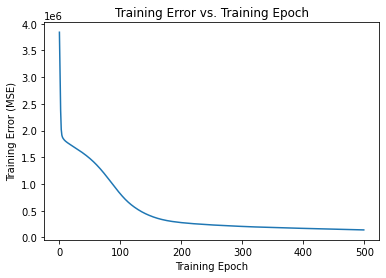

In [22]:
# Plot Training Error
plt.plot(train_loss_history)
plt.title('Training Error vs. Training Epoch')
plt.ylabel('Training Error (MSE)')
plt.xlabel('Training Epoch')
plt.show()

[Text(0, 0.5, 'Testing Mean Average Percentage Error'),
 Text(0.5, 0, 'Training Epoch')]

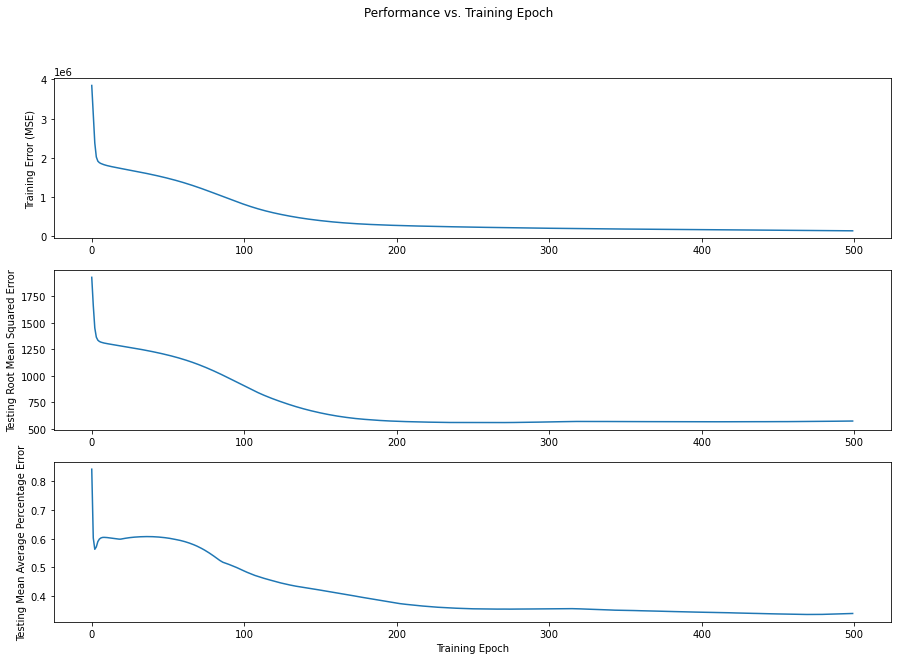

In [23]:
# Plot training error, and testing results
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_figheight(10)
fig.set_figwidth(15)
fig.suptitle('Performance vs. Training Epoch')
ax1.plot(train_loss_history)
ax2.plot(test_history_RMSE)
ax3.plot(test_history_MAPE)
ax1.set(ylabel = 'Training Error (MSE)')
ax2.set(ylabel ='Testing Root Mean Squared Error')
ax3.set(ylabel ='Testing Mean Average Percentage Error', xlabel ='Training Epoch')

In [24]:
# Now to make predictions and evaluate model
test_vals = test(test_dataloader, model)
print(f"Root Mean Squared Error: {math.sqrt(test_vals['Error_sq'].sum() / test_vals['Error_sq'].count())}")
print(f"Mean Average Percentage Error: {test_vals['Perc_Err'].mean()}")

Root Mean Squared Error: 571.4369868242302
Mean Average Percentage Error: 0.3401263413788762


In [25]:
test_vals

,Actual,Predicted,Error,Error_sq,Perc_Err
0,1400.199951,1549.348145,149.148193,2.224518e+04,0.106519
1,982.500000,961.523315,20.976685,4.400213e+02,0.021350
2,1336.699951,1774.285522,437.585571,1.914811e+05,0.327363
3,940.500000,2405.321777,1464.821777,2.145703e+06,1.557493
4,1168.900024,1368.295288,199.395264,3.975847e+04,0.170584
5,801.900024,774.882751,27.017273,7.299330e+02,0.033692
6,768.700012,1228.095093,459.395081,2.110438e+05,0.597626
7,7117.200195,6878.367676,238.832520,5.704097e+04,0.033557
8,1595.400024,1228.095093,367.304932,1.349129e+05,0.230227
9,1830.300049,1409.849854,420.450195,1.767784e+05,0.229717
